# Reporte de educación e inclusión en la industria de la tecnología en países hispanos

*Nota:* este reporte está pensado para visualizar datos, resultados y conclusiones. El código detrás está oculto porque ya se realizó en los notebooks anteriores y no es relevante para el propósto de este.

### Temática

El foco de la investigación respecto a la educación será entre la **educación tradicional** (escuelas, universidades, etc.) vs. la **educación NO tradicional** (autodidacta, online, etc.) y su impacto en el empleo y salario.

También se abordará el punto de vista de la **inclusión**.

Esta investigación está centrada en los **países hispanos y Brasil**.

#### 📊 Data: [encuesta 2021 de Stack Ovelfow](https://insights.stackoverflow.com/survey)

### Grupo estudiado

~6300 encuestados de países hispanos y Brasil, de todas las edades.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import os
from scipy import stats
from hypothesize.utilities import trim_mean
from hypothesize.compare_groups_with_single_factor import pb2gen

# read the data
path = os.path.join(os.getcwd(), os.pardir, 'data', 'processed')
df = pd.read_csv(os.path.join(path, 'survey.csv'))

# set styles
sns.set_theme()
pio.templates.default = 'ggplot2'

# function fro plotting
def barploth_normalized(data, title='Title', figsize=(9, 5), padding=-30, label=True):

    if data.shape[0] < 30:
        df_plot = data
    else:
        df_plot = data.value_counts(normalize=True)

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.barplot(x=round(df_plot*100, 1), y=df_plot.index)
    if label:
        ax.bar_label(ax.containers[0], padding=padding, size=11)
    plt.title(title, size=15)
    plt.xlabel('Porcentaje (%)', size=13)
    plt.margins(0.02)
    plt.show()

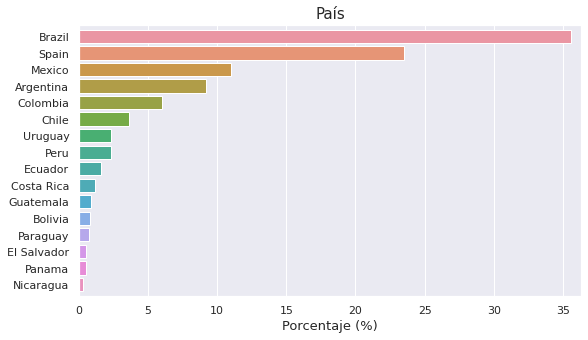

In [2]:
barploth_normalized(data=df.Country, title='País', label=False)

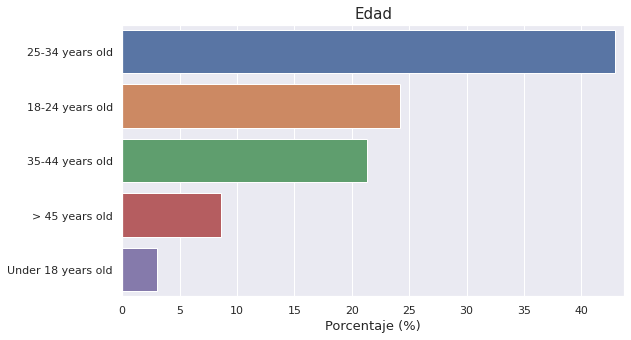

In [3]:
barploth_normalized(df.Age, title='Edad', label=False)

### Educación

De este grupo, el `68,2%` tienen título universitario y un `31,8%` no lo tienen. Este es el porcentaje del nivel académico registrado:

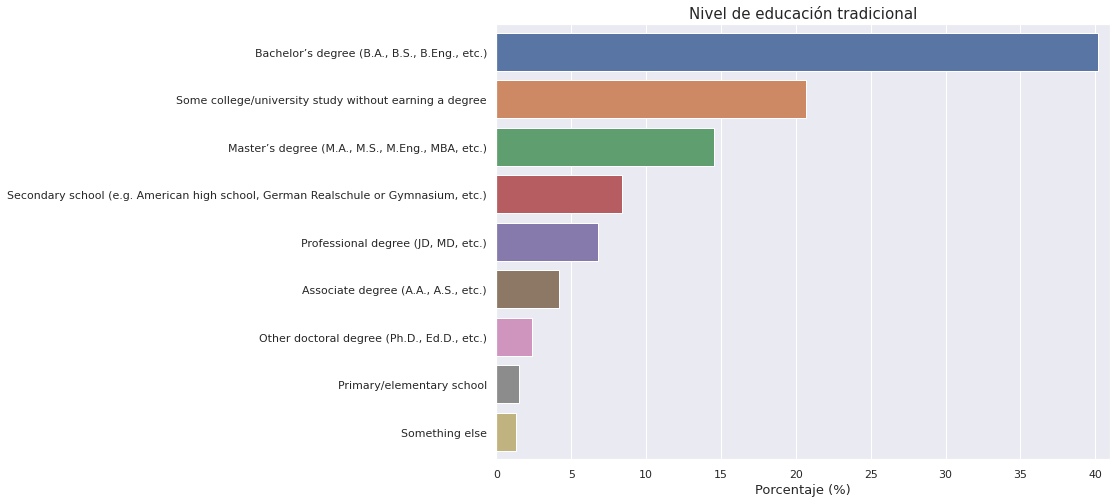

In [4]:
barploth_normalized(df.EdLevel, title='Nivel de educación tradicional', label=False, figsize=(11,8))

Sin importar la edad o el tener título, la mayoría aprendió a programar de manera no tradicional (online, autodidacta, etc.), y lo menos común es que se aprenda únicamente de forma tradicional (solo en la escuela).

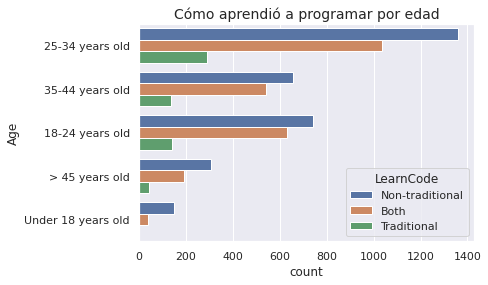

In [5]:
sns.countplot(y=df.Age, hue=df.LearnCode, hue_order=['Non-traditional', 'Both', 'Traditional'])
plt.title('Cómo aprendió a programar por edad', size=14)
plt.show()

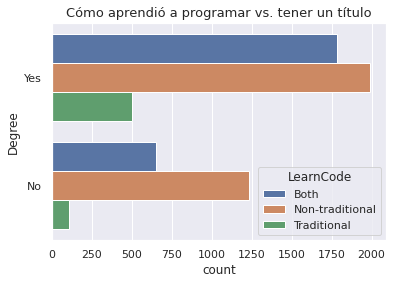

In [6]:
sns.countplot(y=df.Degree, hue=df.LearnCode)
plt.title('Cómo aprendió a programar vs. tener un título', size=13)
plt.show()

### Empleo

La mayoría de los encuestados tienen trabajo, el resto del análisis se centrará en este grupo ya que se tiene el registro de sus ganancias anuales.

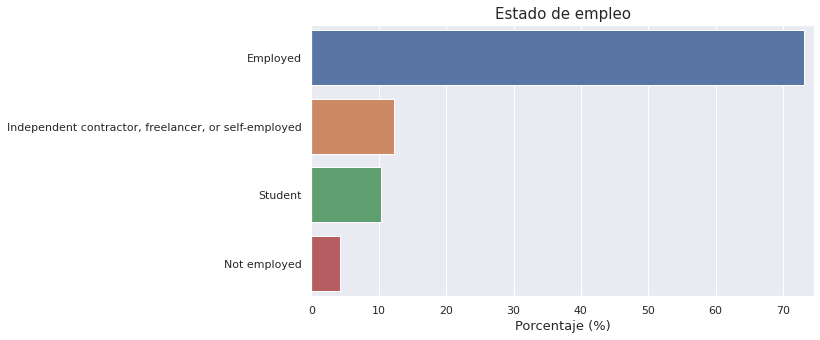

In [7]:
barploth_normalized(df.Employment, title='Estado de empleo', label=False)

Omitiendo a los que aún están estudiando, **¿el tener un título universitario influyó en conseguir empleo?**

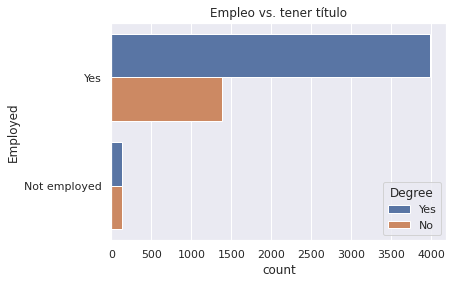

Power_divergenceResult(statistic=array([1.34328358e-01, 1.26539732e+03]), pvalue=array([7.13985796e-001, 3.74065418e-277]))
CON TÍTULO relación empleo/desempleo: 30.450381679389313 empleados por cada 1 desempleado (3.28% de desempleo)
SIN TÍTULO relación empleo/desempleo: 10.087591240875913 empleados por cada 1 desempleado (9.91% de desempleo)


In [8]:
# Reducir variables a tiene o no empleo
df_employment = pd.DataFrame(df[['Degree', 'Age']])
df_employment['Employed'] = df.Employment.where(df.Employment.isin(['Not employed', 'Student']), 'Yes')
df_employment.drop(df_employment.Employed[df_employment.Employed == 'Student'].index, inplace=True)

# Plot
sns.countplot(hue=df_employment.Degree, y=df_employment.Employed)
plt.title('Empleo vs. tener título')
plt.show()

# Chisquare test
x = df_employment.groupby(['Degree', 'Employed'])['Degree'].count().values.reshape(2,2)
print(stats.chisquare(x))

# Rates
d = df_employment.groupby(['Degree', 'Employed'])['Degree'].count()
print(f'CON TÍTULO relación empleo/desempleo: {d[3]/d[2]} empleados por cada 1 desempleado ({round(d[2]/d[3]*100,2)}% de desempleo)')
print(f'SIN TÍTULO relación empleo/desempleo: {d[1]/d[0]} empleados por cada 1 desempleado ({round(d[0]/d[1]*100,2)}% de desempleo)')

- Se puede inferir que **sí influye tener título universitario** para conseguir empleo.

Si se analiza las ganancias anuales por el nivel de educación, se obtiene estos rangos:

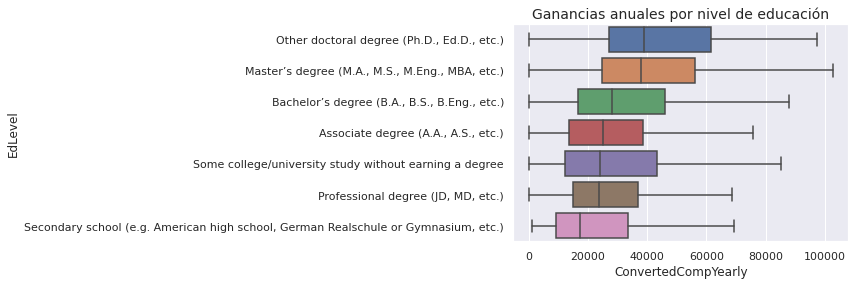

In [9]:
# New DataFrame
edu = pd.DataFrame(df[['EdLevel', 'ConvertedCompYearly']])
edu.drop(edu.EdLevel[edu.EdLevel.isin(['Primary/elementary school', 'Something else'])].index, inplace=True)

# List to order data
median_salary = edu.groupby('EdLevel')[['ConvertedCompYearly']].agg(np.median) \
.sort_values(by='ConvertedCompYearly', ascending=False)

# Plot
sns.boxplot(y=edu.EdLevel, 
            x=edu.ConvertedCompYearly, 
            order=list(median_salary.index), 
            showfliers=False)
plt.title('Ganancias anuales por nivel de educación', size=14)
plt.show()

A simple vista parece que tener mejores salarios está ligado a tener un mayor título universitario. Así que surge la pregunta:

**¿El tener título hace que una persona tenga mayores ganancias anualmente respecto a si no lo tiene?**

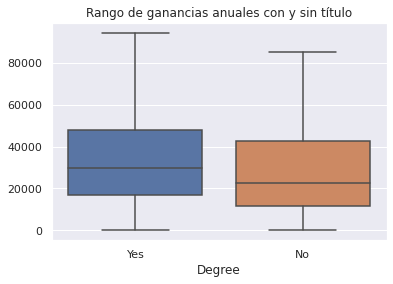

p-value = 0.0
Confidence interval = [4387.410483252526, 7793.142532901245]


In [10]:
# Plot
sns.boxplot(x=df.Degree, y=df.ConvertedCompYearly, showfliers=False)
plt.title('Rango de ganancias anuales con y sin título')
plt.ylabel(None)
plt.show()

# Diferencia entre las ganancias anuales
s_has_degree = df.ConvertedCompYearly[(df.Degree == 'Yes') & (df.ConvertedCompYearly.notnull())]
s_not_degree = df.ConvertedCompYearly[(df.Degree == 'No') & (df.ConvertedCompYearly.notnull())]

# Hypothesis test
test = pb2gen(s_has_degree, s_not_degree, trim_mean, .2)
print(f'p-value = {test["p_value"]}')
print(f'Confidence interval = {test["ci"]}')

- Hay significancia estadística para inferir que **si una persona tiene título gana más que si no.**
- El rango de ganancias extra anuales al tener título va de `4k` a `7k` dólares.

**¿Haber aprendido código de forma no tradicional inluye en los ingresos?**

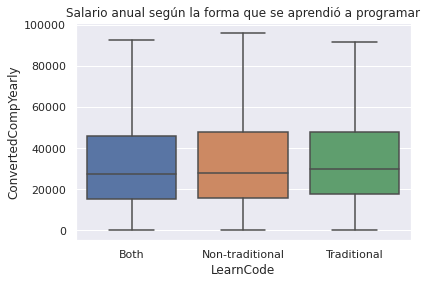

p-value = 0.7386


In [11]:
# Plot
sns.boxplot(x=df.LearnCode, y=df.ConvertedCompYearly, showfliers=False)
plt.title('Salario anual según la forma que se aprendió a programar')
plt.show()

# Reduzco los datos a: aprendio de forma tradicional o no
df_learn = pd.DataFrame()
df_learn['Salary'] = df.ConvertedCompYearly
df_learn['LearnNoTraditional'] = df.LearnCode.where(df.LearnCode == 'Non-traditional', 'No')
df_learn.LearnNoTraditional.replace('Non-traditional', 'Yes', inplace = True)

# Hypothesis test
not_traditional = df_learn.Salary[df_learn.LearnNoTraditional == 'Yes'].dropna()
traditional = df_learn.Salary[df_learn.LearnNoTraditional == 'No'].dropna()
test = pb2gen(not_traditional, traditional, trim_mean, 0.2, nboot=10000)
print(f'p-value = {test["p_value"]}')

- No hay significancia estadística como para asegurar que existe una diferencia de salarios según el tipo de forma que se aprendió a programar.

Por último, **¿toma menos tiempo aprender a programar profesionalmente si se aprende de forma NO tradicional?**

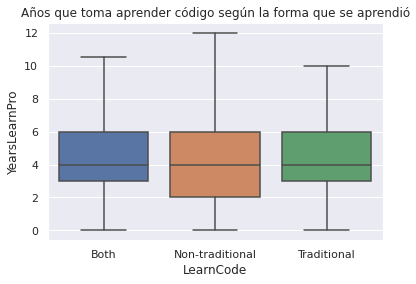

p-value = 0.00039999999999995595
Confidence interval = [-0.7783269105650366, -0.23828574645913614]


In [12]:
# New variables
traditional = df[df['LearnCode'] == 'Traditional']['YearsLearnPro'].dropna()
non_traditional = df[df['LearnCode'] == 'Non-traditional']['YearsLearnPro'].dropna()

# Plot
sns.boxplot(x=df.LearnCode, y=df.YearsLearnPro, showfliers=False)
plt.title('Años que toma aprender código según la forma que se aprendió')
plt.show()

# Hypothesis test
t_y = pb2gen(non_traditional, traditional, trim_mean, 0.2, nboot=10000)
print(f'p-value = {t_y["p_value"]}')
print(f'Confidence interval = {t_y["ci"]}')

- Si se aprende de forma NO tradicional se puede llegar a ser profesional de `0.2` a `0.7` años más pronto.

## Inclusión

Hay una brecha de género, el `92.7%` de las personas encuestadas se identifican como **hombres**. De ahí surge una pregunta:

**¿Hombres y mujeres ganan lo mismo?**

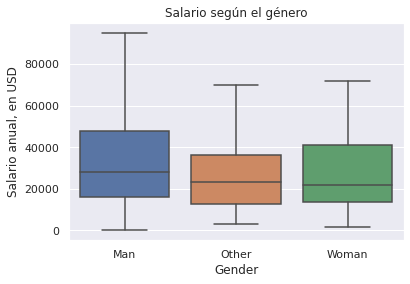

p-value = 0.0028
ci = [2016.2085068603737, 8841.032598870053]


In [13]:
# new variables
man_salary = df[df['Gender'] == 'Man']['ConvertedCompYearly'].dropna()
woman_salary = df[df['Gender'] == 'Woman']['ConvertedCompYearly'].dropna()

# plot
sns.boxplot(x=df.Gender, y=df.ConvertedCompYearly, showfliers=False)
plt.title('Salario según el género')
plt.ylabel('Salario anual, en USD')
plt.show()

# hypothesis test
t_mw = pb2gen(man_salary, woman_salary, trim_mean, 0.2, nboot=10000)
print(f'p-value = {t_mw["p_value"]}')
print(f'ci = {t_mw["ci"]}')

- Los hombres ganan de `2k` a `8k` dólares extra anuales más que las mujeres.

**¿La orientación sexual de una persona influye en su salario anual percibido?**

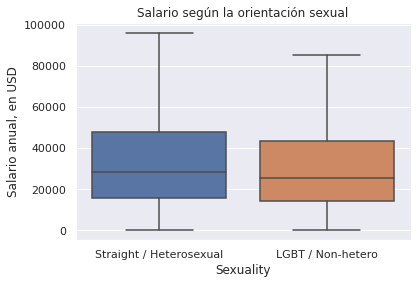

p-value = 0.0012000000000000899
ci = [-5191.073259004876, -1366.0027128318507]


In [14]:
# new variables
hetero_salary = df[df['Sexuality'] == 'Straight / Heterosexual']['ConvertedCompYearly'].dropna()
non_hetero_salary = df[df['Sexuality'] == 'LGBT / Non-hetero']['ConvertedCompYearly'].dropna()

# plot
sns.boxplot(x=df.Sexuality, y=df.ConvertedCompYearly, showfliers=False)
plt.title('Salario según la orientación sexual')
plt.ylabel('Salario anual, en USD')
plt.show()

# hypothesis test
t_s = pb2gen(non_hetero_salary, hetero_salary, trim_mean, 0.2, nboot=10000)
print(f'p-value = {t_s["p_value"]}')
print(f'ci = {t_s["ci"]}')


- Sí influye, quienes **NO se identifican como heterosexuales** perciben de `1k` a `5k` dólares **menos** al año.

## Conclusiones

- El tener un título universitario **sí influye** en las probabilidades de conseguir empleo.
- Tener título universitario, según su nivel, puede **aumentar las ganancias anuales** entre `4k` y `7k` dólares.
- La tendencia apunta a que las personas aprenden a programar principalmente de una manera no tradicional (autodidacta, online, etc.).
- El haber aprendido a programar de una manera no tradicional o no, **no influye** en los ingresos percibidos. 
- Pero sí lleva a que se pueda hacerlo profesionalmente entre `0.2` y `0.7` años **más pronto** que si se lo hace de una manera puramente tradicional.
- Las mujeres son minoría y ganan de `2k` a `8k` dólares anuales **menos que los hombres**.
- Las personas que NO se identifican como heterosexuales ganan de `1k` a `5k` dólares anuales **menos** que los que sí lo hacen.

## Accionables

- Elegir seguir una educación tradicional puede aumentar las probabilidades de conseguir un empleo y el ingreso anual percibido. Además, acompañarlo con una educación no tradicional es la mejor opción para llegar a desarrollar profesionalmente en menos tiempo.
- Evitar dar discursos en contra de la educación tradicional. Hay outliers en todas las categorías, pero los datos muestran que la mejor opción, si se tiene las posibilidades, es combinar ambos tipos de educación.
- Crear programas que incentiven a **más mujeres** a ingresar a la industria tech y disminuir la brecha de género.
- Crear regulaciones a las empresas para que **todas las personas** tengan acceso a los **mismos salarios** y posibilidades de ascenso por su nivel técnico y humano, más no por su género u orientación sexual.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09491c61-3767-4289-98fd-88aee19bb45d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>